In [ ]:
# ✅ STEP 1: Mount Drive (if using Colab)
from google.colab import drive
import os
import shutil

mountpoint = '/content/drive'

try:
  drive.mount(mountpoint, force_remount=True)
except ValueError:
  print("Google Drive is already mounted. Unmounting and remounting.")
  drive.flush_and_unmount()
  # Check if the directory exists and is not a mount point, then remove it
  if os.path.exists(mountpoint) and not os.path.ismount(mountpoint):
      shutil.rmtree(mountpoint) # Use shutil.rmtree for non-empty directory
  drive.mount(mountpoint, force_remount=True)

Mounted at /content/drive


In [ ]:
# ✅ STEP 2: Install Required Packages
!pip install -q keras scikit-learn matplotlib seaborn opencv-python tensorflow

In [ ]:
# ✅ STEP 3: Set Paths and Create Result Directory
import os
train_dir = '/content/drive/MyDrive/brisc2025/tumor/train'
test_dir = '/content/drive/MyDrive/brisc2025/tumor/test'
save_dir = '/content/drive/MyDrive/brisc2025/ensembled/brain_tumor_results'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# ✅ STEP 4: Data Augmentation and Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 4002 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [ ]:
# ✅ STEP 5: Define Models
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
num_classes = train_gen.num_classes

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_alexnet():
    model = models.Sequential([
        layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Conv2D(256, (5,5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Conv2D(384, (3,3), activation='relu', padding='same'),
        layers.Conv2D(384, (3,3), activation='relu', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_mesresnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:20]:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
# ✅ STEP 6: Compile & Train Function
def compile_and_train(model, name):
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=20)
    model.save(f'{save_dir}/{name}.h5')
    return model, history

In [ ]:
# ✅ STEP 7: Train Base Models
models_dict = {}
histories = {}

for name, builder in {
    "CNN": create_cnn,
    "AlexNet": create_alexnet,
    "ResNet50": resnet50,
    "MesResNet50": create_mesresnet50
}.items():
    print(f"\nTraining {name}...")
    model, history = compile_and_train(builder(), name)
    models_dict[name] = model
    histories[name] = history


Training CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1965s 16s/step - accuracy: 0.4412 - loss: 1.2119 - val_accuracy: 0.4589 - val_loss: 1.2691
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.6195 - loss: 0.9104 - val_accuracy: 0.6082 - val_loss: 1.0678
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.6687 - loss: 0.8110 - val_accuracy: 0.6162 - val_loss: 1.1141
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 505ms/step - accuracy: 0.7174 - loss: 0.7154 - val_accuracy: 0.6774 - val_loss: 0.9147
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.7158 - loss: 0.7246 - val_accuracy: 0.6804 - val_loss: 1.1114
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.7373 - loss: 0.6762 - val_accuracy: 0.6814 - val_loss: 1.0396
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 507ms/step - accuracy: 0.7633 - loss: 0.6216 - val_accuracy: 0.7044 - val_loss: 0.9620
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 507ms/step - accuracy: 0.7582 - loss: 0


Training AlexNet...
Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 89s 647ms/step - accuracy: 0.3841 - loss: 1.3111 - val_accuracy: 0.3627 - val_loss: 1.6304
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - accuracy: 0.5559 - loss: 0.9778 - val_accuracy: 0.5551 - val_loss: 1.2529
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.6599 - loss: 0.7892 - val_accuracy: 0.6253 - val_loss: 1.2663
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.7388 - loss: 0.6265 - val_accuracy: 0.6513 - val_loss: 0.9437
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.7799 - loss: 0.5562 - val_accuracy: 0.7525 - val_loss: 0.7427
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.8018 - loss: 0.5242 - val_accuracy: 0.7385 - val_loss: 0.8817
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.8450 - loss: 0.4015 - val_accuracy: 0.7896 - val_loss: 0.8140
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - accur


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 117s 663ms/step - accuracy: 0.4952 - loss: 1.1307 - val_accuracy: 0.3687 - val_loss: 1.3975
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.6484 - loss: 0.8384 - val_accuracy: 0.3858 - val_loss: 1.5046
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.6563 - loss: 0.7773 - val_accuracy: 0.3677 - val_loss: 2.0800
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.6794 - loss: 0.7634 - val_accuracy: 0.4559 - val_loss: 1.7380
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.7148 - loss: 0.7143 - val_accuracy: 0.5451 - val_loss: 1.1874
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 500ms/step - accuracy: 0.7169 - loss: 0.6899 - val_accuracy: 0.6062 - val_loss: 1.3870
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.7367 - loss: 0.6373 - val_accuracy: 0.5922 - val_loss: 1.1343
Epoch 8/2


Training MesResNet50...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 143s 721ms/step - accuracy: 0.4641 - loss: 1.4283 - val_accuracy: 0.3176 - val_loss: 1.8792
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 507ms/step - accuracy: 0.7365 - loss: 0.7111 - val_accuracy: 0.3277 - val_loss: 2.1188
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.8179 - loss: 0.5196 - val_accuracy: 0.5421 - val_loss: 1.5313
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 508ms/step - accuracy: 0.8350 - loss: 0.4500 - val_accuracy: 0.7184 - val_loss: 1.0640
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 508ms/step - accuracy: 0.8486 - loss: 0.4100 - val_accuracy: 0.7695 - val_loss: 0.9504
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 508ms/step - accuracy: 0.8820 - loss: 0.3388 - val_accuracy: 0.7876 - val_loss: 0.6935
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 507ms/step - accuracy: 0.9170 - loss: 0.2472 - val_accuracy: 0.8226 - val_loss: 0.7709
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.8812 - loss: 

Evaluating CNN


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 461s 15s/step


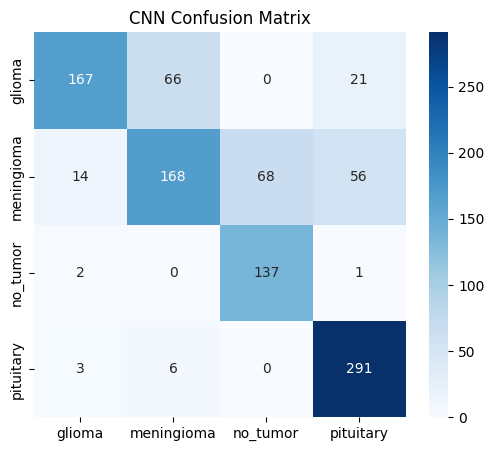

Evaluating AlexNet
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step


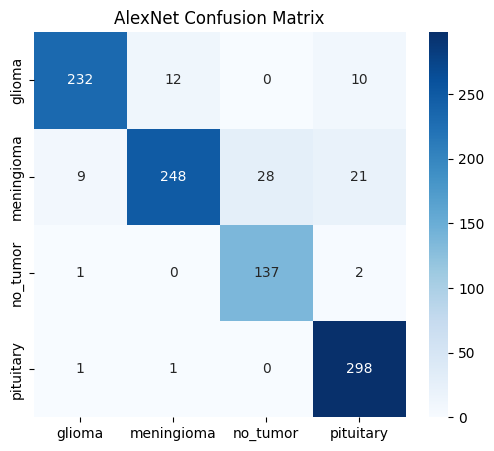

Evaluating ResNet50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step


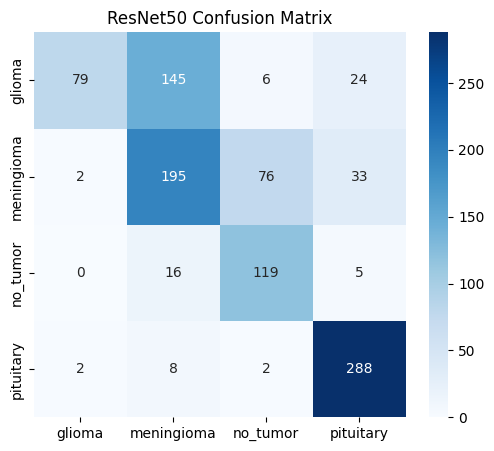

Evaluating MesResNet50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step


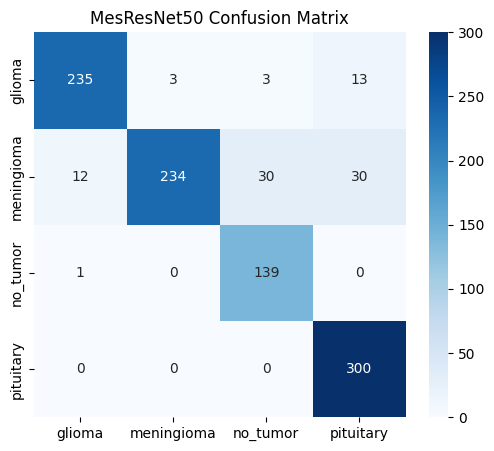

In [ ]:
# ✅ STEP 8: Evaluation & Metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

def evaluate_model(name, model):
    pred = model.predict(test_gen)
    y_pred = np.argmax(pred, axis=1)
    y_true = test_gen.classes
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)


    # Save confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"{save_dir}/{name}_conf_matrix.png")
    plt.show()
    plt.close()

    # ROC Curve (binary/multiclass one-vs-rest)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), pred.ravel())
    roc_auc = auc(fpr, tpr)

    return {
        "accuracy": report['accuracy'],
        "precision": np.mean([report[str(i)]['precision'] for i in range(num_classes)]),
        "recall": np.mean([report[str(i)]['recall'] for i in range(num_classes)]),
        "f1_score": np.mean([report[str(i)]['f1-score'] for i in range(num_classes)]),
        "roc_auc": roc_auc,
        "probs": pred
    }

results = {}
probs_dict = {}

for name, model in models_dict.items():
    print(f"Evaluating {name}")
    eval_res = evaluate_model(name, model)
    results[name] = {k:v for k,v in eval_res.items() if k!="probs"}
    probs_dict[name] = eval_res["probs"]

Evaluating Soft Voting Ensemble...


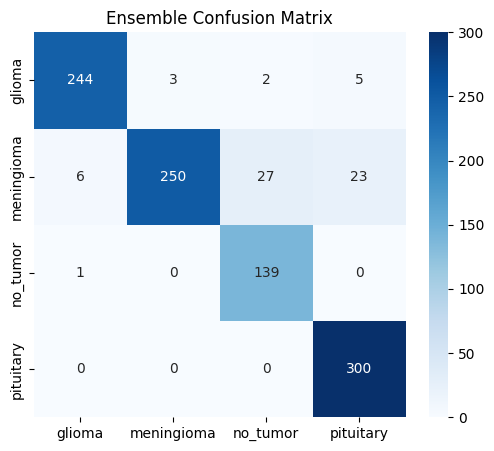

In [ ]:
# ✅ STEP 9: Soft Voting Ensemble (AlexNet + MesResNet50)
print("Evaluating Soft Voting Ensemble...")
ensemble_probs = (probs_dict["AlexNet"] + probs_dict["MesResNet50"]) / 2.0
y_pred = np.argmax(ensemble_probs, axis=1)
y_true = test_gen.classes
report = classification_report(y_true, y_pred, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Ensemble Confusion Matrix')
plt.savefig(f"{save_dir}/Ensemble_conf_matrix.png")
plt.show()
plt.close()

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), ensemble_probs.ravel())
roc_auc = auc(fpr, tpr)

results["Ensemble"] = {
    "accuracy": report['accuracy'],
    "precision": np.mean([report[str(i)]['precision'] for i in range(num_classes)]),
    "recall": np.mean([report[str(i)]['recall'] for i in range(num_classes)]),
    "f1_score": np.mean([report[str(i)]['f1-score'] for i in range(num_classes)]),
    "roc_auc": roc_auc
}


             accuracy  precision    recall  f1_score   roc_auc
CNN             0.763   0.763690  0.788768  0.759658  0.896218
AlexNet         0.915   0.908882  0.923937  0.912819  0.982448
ResNet50        0.681   0.724146  0.689570  0.657741  0.875936
MesResNet50     0.908   0.904424  0.920690  0.905571  0.979498
Ensemble        0.933   0.925567  0.942620  0.929701  0.984850


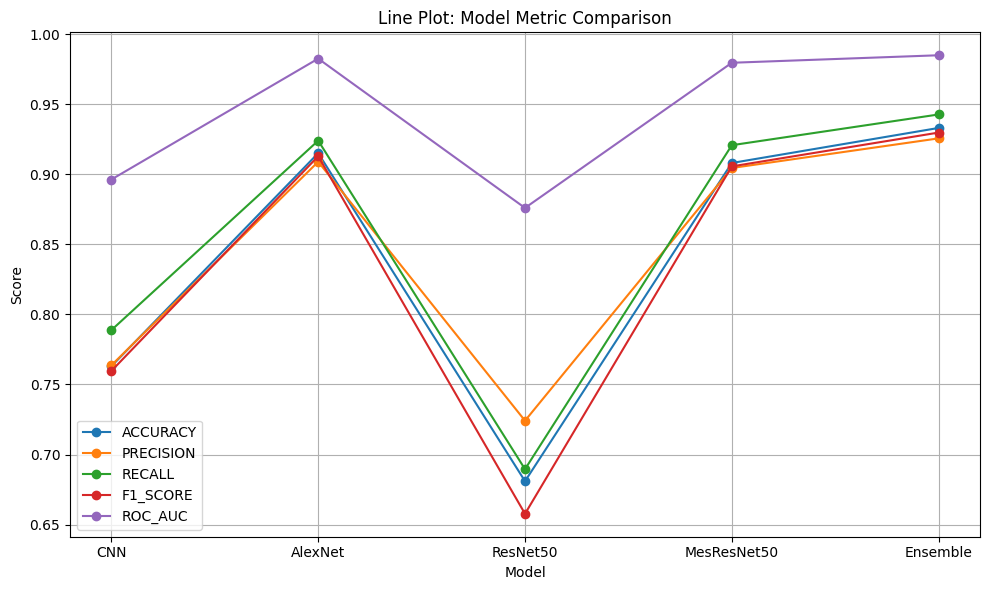

In [ ]:
# ✅ STEP 10: Save Results & Plots
df_results = pd.DataFrame(results).T
df_results.to_csv(f"{save_dir}/model_comparison.csv")
print(df_results)

# Line Plot
metrics_list = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]
plt.figure(figsize=(10, 6))
for metric in metrics_list:
    plt.plot(df_results.index, df_results[metric], marker='o', label=metric.upper())
plt.title("Line Plot: Model Metric Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{save_dir}/lineplot_all_metrics.png")
plt.show()
plt.close()

# Bar Plots
for metric in metrics_list:
    plt.figure()
    df_results[metric].plot(kind='bar', title=f"{metric.upper()} Comparison", color='skyblue')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{metric}_comparison.png")
    plt.close()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Example: softmax probabilities from both models
# probs_alexnet.shape = (n_samples, n_classes)
# probs_mesresnet50.shape = (n_samples, n_classes)

# Assign weights (you can tune these)
w1 = 0.4  # weight for AlexNet
w2 = 0.6  # weight for MesResNet50

# Weighted average of probabilities
probs_ensemble = (w1 * probs_dict["AlexNet"]) + (w2 * probs_dict["MesResNet50"])

# Final prediction
y_pred_ensemble = np.argmax(probs_ensemble, axis=1)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred_ensemble))
print("Precision:", precision_score(y_true, y_pred_ensemble, average="weighted"))
print("Recall:", recall_score(y_true, y_pred_ensemble, average="weighted"))
print("F1 Score:", f1_score(y_true, y_pred_ensemble, average="weighted"))
print("ROC-AUC:", roc_auc_score(y_true, probs_ensemble, multi_class="ovr"))

Accuracy: 0.919
Precision: 0.9274470410753833
Recall: 0.919
F1 Score: 0.917432232950387
ROC-AUC: 0.9896828338011137


### Training and Validation Plots

Here are the training and validation accuracy and loss plots for the AlexNet and MesResNet models. The soft voting ensemble does not have a training history in the same way as the individual models, so it is not included in these plots.

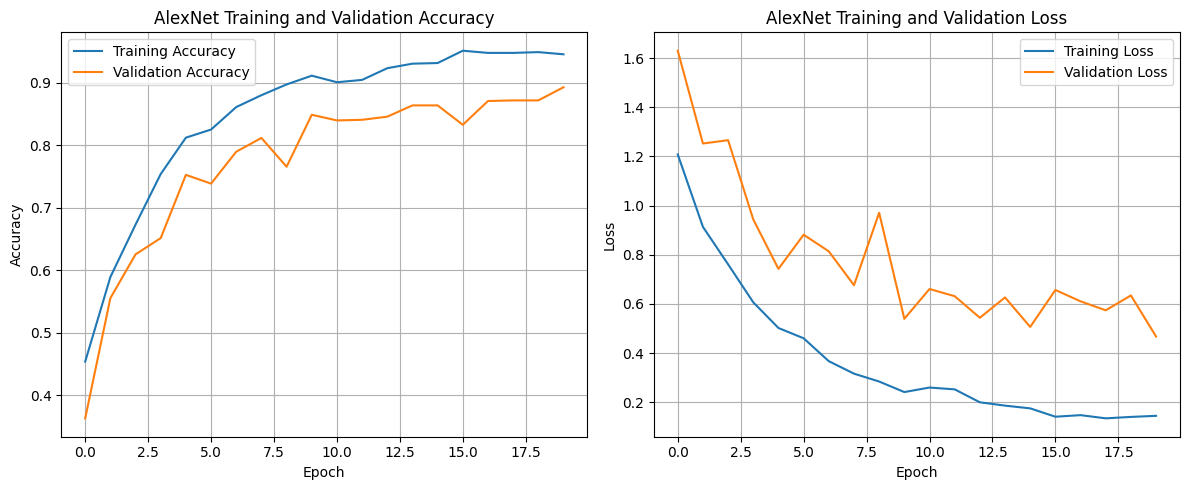

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss for AlexNet
history_alexnet = histories['AlexNet']

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'], label='Training Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('AlexNet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

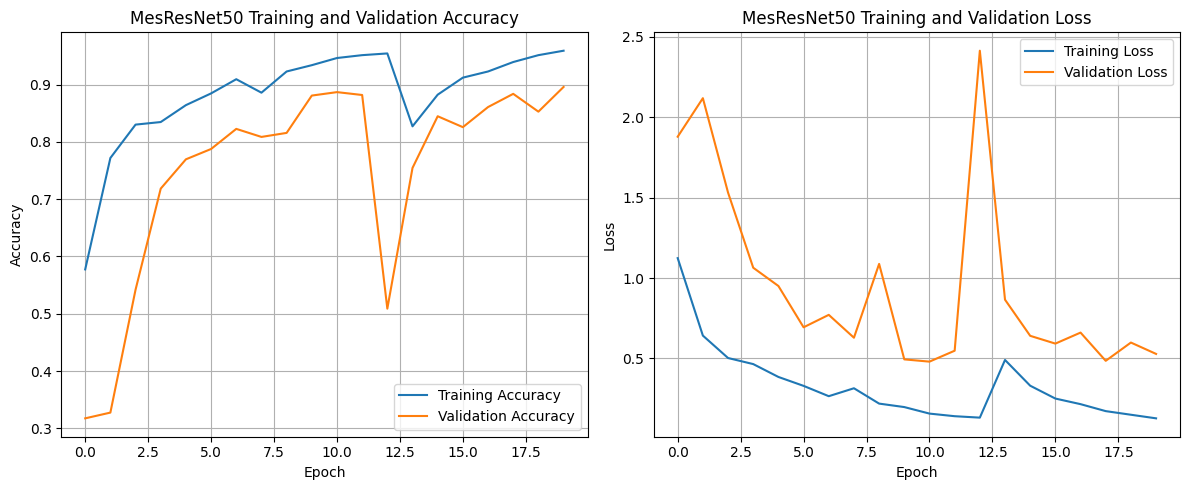

In [ ]:
# Plot training and validation accuracy and loss for MesResNet50
history_mesresnet50 = histories['MesResNet50']

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_mesresnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_mesresnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('MesResNet50 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_mesresnet50.history['loss'], label='Training Loss')
plt.plot(history_mesresnet50.history['val_loss'], label='Validation Loss')
plt.title('MesResNet50 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

print("Ensemble Model Evaluation Metrics:")
display(df_results.loc[["Ensemble"]])

Ensemble Model Evaluation Metrics:


,accuracy,precision,recall,f1_score,roc_auc
Ensemble,0.933,0.925567,0.94262,0.929701,0.98485


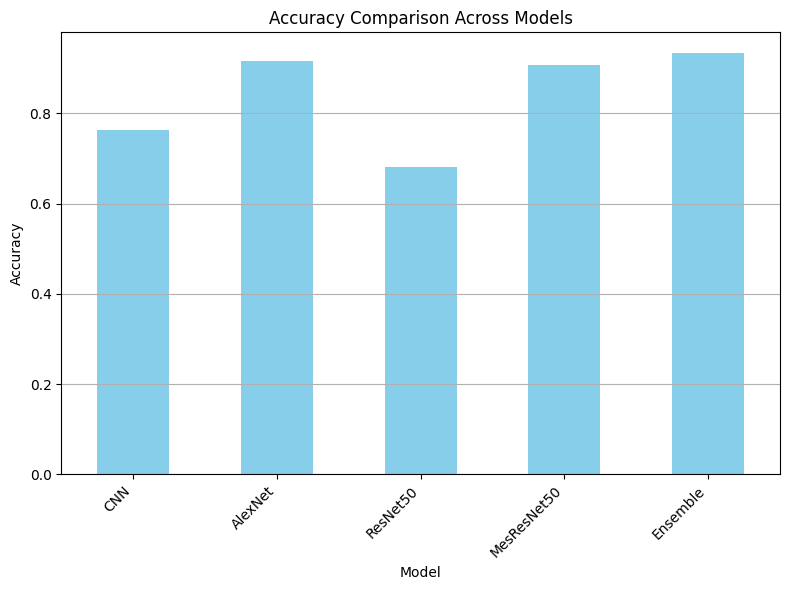

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_results contains the metrics for all models including the ensemble
plt.figure(figsize=(8, 6))
df_results['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()